In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import scipy
from scipy import signal

import wfdb
from wfdb import processing
import pandas as pd
import sys

import random

import seaborn as sns

from hrv.filters import quotient, moving_median
from scipy import interpolate
from tqdm import tqdm

In [2]:
def get_qrs_amp(ecg, qrs):
    interval = int(FS * 0.250)
    qrs_amp = []
    for index in range(len(qrs)):
        curr_qrs = qrs[index]
        amp = np.max(ecg[curr_qrs-interval:curr_qrs+interval])
        qrs_amp.append(amp)

    return qrs_amp

def create_time_info(rri):
    rri_time = np.cumsum(rri) / 1000.0  # make it seconds
    return rri_time - rri_time[0]   # force it to start at zero

def create_interp_time(rri, fs):
    time_rri = create_time_info(rri)
    return np.arange(0, time_rri[-1], 1 / float(fs))

def interp_cubic_spline(rri, fs):
    time_rri = create_time_info(rri)
    time_rri_interp = create_interp_time(rri, fs)
    tck = interpolate.splrep(time_rri, rri, s=0)
    rri_interp = interpolate.splev(time_rri_interp, tck, der=0)
    return time_rri_interp, rri_interp

In [3]:
# train data

FS = 100
index = 10
MARGIN = 10
FS_INTP = 4
MAX_HR = 300.0
MIN_HR = 20.0
MIN_RRI = 1.0 / (MAX_HR / 60.0) * 1000
MAX_RRI = 1.0 / (MIN_HR / 60.0) * 1000

train_features = []
train_labels = []

data_path = os.getcwd()+'/data/'
name_lst = ['a', 'b', 'c']
for prefix in name_lst:
    if prefix == 'a':
        range_ = 19
    elif prefix == 'b':
        range_ = 4
    elif prefix == 'c':
        range_ = 9
    
    for i in range(1, range_):
        if i < 10:
            name = prefix + '0' + str(i)
        else:
            name = prefix + str(i)
        
        print(name)
        win_num = len(wfdb.rdann(data_path+name, 'apn').symbol)
        signals, fields = wfdb.rdsamp(data_path+name)
        
        for index in tqdm(range(1, win_num)):
            samp_from = index * 60 * FS # 60 seconds
            samp_to = samp_from + 60 * FS  # 60 seconds


            qrs_ann = wfdb.rdann(data_path+name, 'qrs', sampfrom=samp_from - (MARGIN*100), sampto=samp_to + (MARGIN*100)).sample
            apn_ann = wfdb.rdann(data_path+name, 'apn', sampfrom=samp_from, sampto=samp_to - 1).symbol
            qrs_amp = get_qrs_amp(signals, qrs_ann)
            rpeaks = np.diff(qrs_ann)
            rpeaks_ms = rpeaks.astype('float') / FS * 1000.0

            try:
                rri_filt = moving_median(rpeaks_ms)

                if len(rri_filt) > 5 and (np.min(rri_filt) >= MIN_RRI and np.max(rri_filt) <= MAX_RRI):
                    time_intp, rri_intp = interp_cubic_spline(rri_filt, FS_INTP)
                    rri_intp = rri_intp[(time_intp >= MARGIN) & (time_intp < (60+MARGIN))]

                    # qrs_time_intp, qrs_intp = interp_cubic_spline_qrs(qrs_ann, qrs_amp, FS_INTP)

                    # calculate features: mean, rmssd, sdsd, pNN50
                    mean = np.mean(rpeaks_ms) # mean of rr interval

                    NN50 = np.diff(rpeaks_ms) # NN50: the number of interval differences of successive NN intervals greater than 50 ms
                    pNN50 = sum(NN50 > 50) / len(rpeaks_ms) #pNN50: NN50/number of rr interval

                    rmssd_result = 0
                    sdsd_result = 0
                    count = 0
                    sd = np.std(rpeaks_ms)
                    for j in range(len(rpeaks_ms)-1):
                        sdsd_result += ((rpeaks_ms[j] - rpeaks_ms[j+1]) - mean) ** 2
                        rmssd_result += (rpeaks_ms[j]-rpeaks_ms[j+1]) ** 2
                        count += 1
                    rmssd = np.sqrt(rmssd_result/count)
                    sdsd = np.sqrt(sdsd_result/count)

                    if len(rri_intp) == FS_INTP * 60:
                        rri_intp = rri_intp - np.mean(rri_intp)

                        if apn_ann[0] == 'N':
                            label = 0.0
                        elif apn_ann[0] == 'A':
                            label = 1.0
                        else:
                            label = 2.0

                        train_features.append([rri_intp, mean, sd, sdsd, rmssd, pNN50])
                        train_labels.append(label)

            except:
                pass
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)

  0%|          | 0/488 [00:00<?, ?it/s]

a01


  0%|          | 0/527 [00:00<?, ?it/s]

a02


  0%|          | 0/518 [00:00<?, ?it/s]

a03


  0%|          | 0/491 [00:00<?, ?it/s]

a04


  0%|          | 0/453 [00:00<?, ?it/s]

a05


  0%|          | 0/509 [00:00<?, ?it/s]

a06


  0%|          | 0/510 [00:00<?, ?it/s]

a07


  0%|          | 0/500 [00:00<?, ?it/s]

a08


  0%|          | 0/494 [00:00<?, ?it/s]

a09


  0%|          | 0/516 [00:00<?, ?it/s]

a10


  0%|          | 0/465 [00:00<?, ?it/s]

a11


  0%|          | 0/576 [00:00<?, ?it/s]

a12


  0%|          | 0/494 [00:00<?, ?it/s]

a13


  0%|          | 0/508 [00:00<?, ?it/s]

a14


  0%|          | 0/509 [00:00<?, ?it/s]

a15


  0%|          | 0/481 [00:00<?, ?it/s]

a16


  0%|          | 0/484 [00:00<?, ?it/s]

a17


  0%|          | 0/488 [00:00<?, ?it/s]

a18


  0%|          | 0/486 [00:00<?, ?it/s]

b01


  0%|          | 0/516 [00:00<?, ?it/s]

b02


  0%|          | 0/440 [00:00<?, ?it/s]

b03


  0%|          | 0/483 [00:00<?, ?it/s]

c01


  0%|          | 0/501 [00:00<?, ?it/s]

c02


  0%|          | 0/453 [00:00<?, ?it/s]

c03


  0%|          | 0/481 [00:00<?, ?it/s]

c04


  0%|          | 0/465 [00:00<?, ?it/s]

c05


  0%|          | 0/467 [00:00<?, ?it/s]

c06


  0%|          | 0/428 [00:00<?, ?it/s]

c07


  0%|          | 0/512 [00:00<?, ?it/s]

c08


100%|██████████| 512/512 [04:10<00:00,  2.04it/s]


In [4]:
# test data

FS = 100
index = 10
MARGIN = 10
FS_INTP = 4
MAX_HR = 300.0
MIN_HR = 20.0
MIN_RRI = 1.0 / (MAX_HR / 60.0) * 1000
MAX_RRI = 1.0 / (MIN_HR / 60.0) * 1000

test_features = []
test_labels = []

data_path = os.getcwd()+'/data/'
name_lst = ['a19', 'a20', 'b04', 'b05', 'c09', 'c10']
for name in name_lst:        
    print(name)
    win_num = len(wfdb.rdann(data_path+name, 'apn').symbol)
    signals, fields = wfdb.rdsamp(data_path+name)

    for index in tqdm(range(1, win_num)):
        samp_from = index * 60 * FS # 60 seconds
        samp_to = samp_from + 60 * FS  # 60 seconds


        qrs_ann = wfdb.rdann(data_path+name, 'qrs', sampfrom=samp_from - (MARGIN*100), sampto=samp_to + (MARGIN*100)).sample
        apn_ann = wfdb.rdann(data_path+name, 'apn', sampfrom=samp_from, sampto=samp_to - 1).symbol
        qrs_amp = get_qrs_amp(signals, qrs_ann)
        rpeaks = np.diff(qrs_ann)
        rpeaks_ms = rpeaks.astype('float') / FS * 1000.0

        try:
            rri_filt = moving_median(rpeaks_ms)

            if len(rri_filt) > 5 and (np.min(rri_filt) >= MIN_RRI and np.max(rri_filt) <= MAX_RRI):
                time_intp, rri_intp = interp_cubic_spline(rri_filt, FS_INTP)
                rri_intp = rri_intp[(time_intp >= MARGIN) & (time_intp < (60+MARGIN))]

                # qrs_time_intp, qrs_intp = interp_cubic_spline_qrs(qrs_ann, qrs_amp, FS_INTP)

                # calculate features: mean, rmssd, sdsd, pNN50
                mean = np.mean(rpeaks_ms) # mean of rr interval

                NN50 = np.diff(rpeaks_ms) # NN50: the number of interval differences of successive NN intervals greater than 50 ms
                pNN50 = sum(NN50 > 50) / len(rpeaks_ms) #pNN50: NN50/number of rr interval

                rmssd_result = 0
                sdsd_result = 0
                count = 0
                sd = np.std(rpeaks_ms)
                for j in range(len(rpeaks_ms)-1):
                    sdsd_result += ((rpeaks_ms[j] - rpeaks_ms[j+1]) - mean) ** 2
                    rmssd_result += (rpeaks_ms[j]-rpeaks_ms[j+1]) ** 2
                    count += 1
                rmssd = np.sqrt(rmssd_result/count)
                sdsd = np.sqrt(sdsd_result/count)

                if len(rri_intp) == FS_INTP * 60:
                    rri_intp = rri_intp - np.mean(rri_intp)

                    if apn_ann[0] == 'N':
                        label = 0.0
                    elif apn_ann[0] == 'A':
                        label = 1.0
                    else:
                        label = 2.0

                    test_features.append([rri_intp, mean, sd, sdsd, rmssd, pNN50])
                    test_labels.append(label)

        except:
            pass
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

a19


100%|██████████| 501/501 [05:33<00:00,  1.50it/s]


a20


  0%|          | 0/428 [00:00<?, ?it/s]

b04


  0%|          | 0/432 [00:00<?, ?it/s]

b05


  0%|          | 0/467 [00:00<?, ?it/s]

c09


  0%|          | 0/430 [00:00<?, ?it/s]

c10


100%|██████████| 430/430 [03:12<00:00,  2.23it/s]


In [6]:
len(train_features)

13757

In [7]:
len(train_labels)

13757

In [38]:
normal_rmssd = []
apnea_rmssd = []
normal_pNN50 = []
apnea_pNN50 = []
normal_mean = []
apnea_mean = []
normal_sdsd = []
apnea_sdsd = []
normal_ecg = []
apnea_ecg = []

In [39]:
for i in range(len(train_features)):
    if train_labels[i] == 0.0: #normal
        normal_rmssd.append(train_features[i][4])
        normal_pNN50.append(train_features[i][5])
        normal_mean.append(train_features[i][1])
        normal_sdsd.append(train_features[i][3])
        normal_ecg.append(train_features[i][0])
    elif train_labels[i] == 1.0: #apnea
        apnea_rmssd.append(train_features[i][4])
        apnea_pNN50.append(train_features[i][5])
        apnea_mean.append(train_features[i][1])
        apnea_sdsd.append(train_features[i][3])
        apnea_ecg.append(train_features[i][0])

In [44]:
normal_ecg_ = np.asarray(normal_ecg).ravel()
apnea_ecg_ = np.asarray(apnea_ecg).ravel()

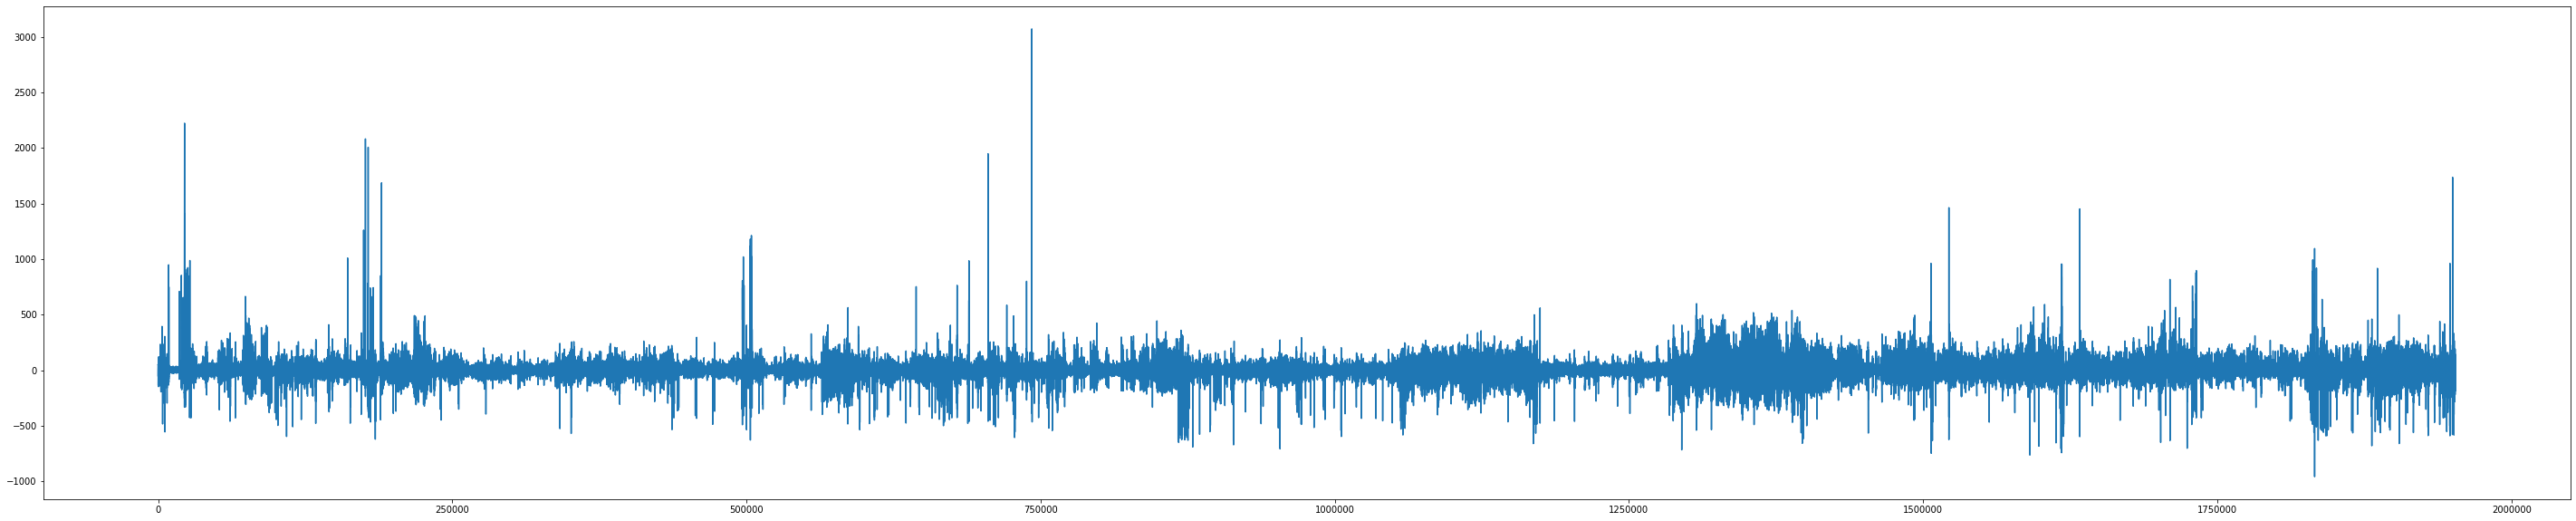

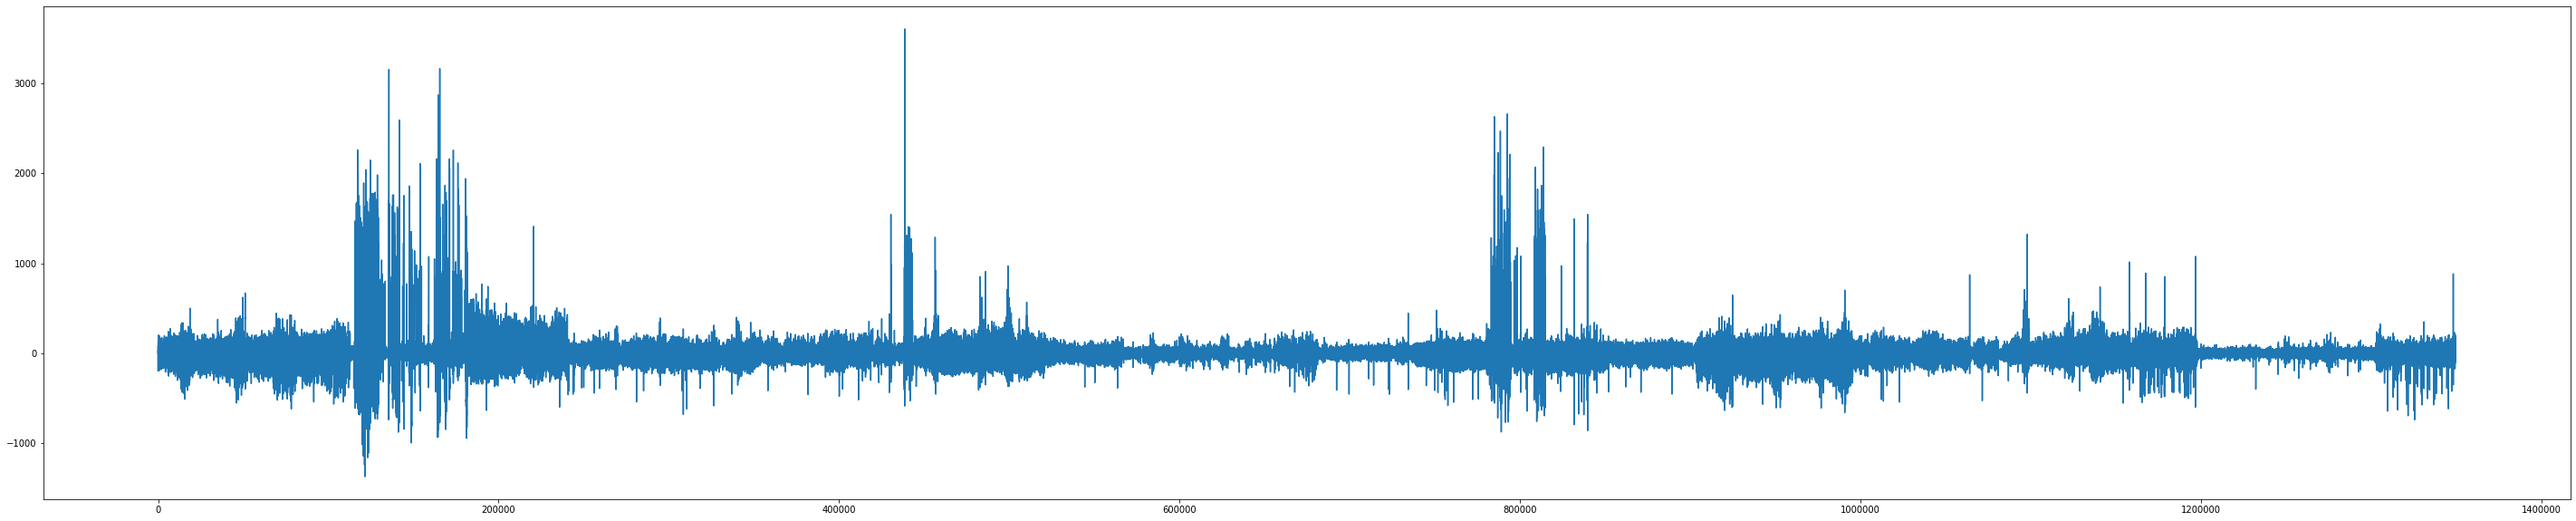

In [47]:
plt.figure(figsize=(50,10))
plt.plot(normal_ecg_)
plt.show()

plt.figure(figsize=(50,10))
plt.plot(apnea_ecg_)

# ML

In [297]:
trainX = np.load('train_features.npy', allow_pickle=True)
trainy = np.load('train_labels.npy', allow_pickle=True)
testX = np.load('test_features.npy', allow_pickle=True)
testy = np.load('test_labels.npy', allow_pickle=True)

In [298]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [299]:
trainX_1 = []
testX_1 = []
for i in range(len(trainX)):
    trainX_1.append(trainX[i][0])
    #trainX_2.append(trainX[i][1:6])
for i in range(len(testX)):
    testX_1.append(testX[i][0])
    #testX_2.append(testX[i][1:6])
trainX_1 = np.asarray(trainX_1)
# trainX_2 = np.asarray(trainX_2, dtype=np.float32)
testX_1 = np.asarray(testX_1)
#testX_2 = np.asarray(testX_2, dtype=np.float32)

In [301]:
trainX_1.shape

(13757, 240)

In [302]:
class data_loader(Dataset):
    def __init__(self, samples, labels, t):
        self.samples = samples
        self.labels = labels
        self.T = t
    
    def __getitem__(self, index):
        sample, target = self.samples[index], self.labels[index]
        if self.T:
            return self.T(sample), target
        else:
            return sample, target
        
    def __len__(self):
        return len(self.samples)

In [303]:
transform = None
train_set = data_loader(trainX_1, trainy, transform)
test_set = data_loader(testX_1, testy, transform)
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [304]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [305]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2), stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2), stride=2)
        )
        
        #self.drop = nn.Dropout(0.2)
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=57 * 64, out_features=1000),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=1000, out_features=500),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=500, out_features = 2)
        )
    
    def forward(self, x):
        #print('x shape: ', x.shape)
        out = self.conv1(x)
        #print('conv1 shape: ', out.shape)
        out = self.conv2(out)
        
        #out = self.drop(out)
        #print('conv2 shape: ', out.shape)
        out = out.reshape(-1, 57 * 64)
        #print('after reshape: ', out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        
        out = self.fc3(out)
        
        out = F.softmax(out, dim = 1)
        return out

In [306]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [307]:
def train(model, optimizer, train_loader, test_loader):
    n_batch = len(train_loader.dataset) // 64
    criterion = nn.CrossEntropyLoss()
    epoch = 100
    best_train_acc = 0
    best_test_acc = 0
    m = nn.Sigmoid()
    for e in range(epoch):
        model.train()
        correct, total_loss = 0, 0
        total = 0
        for index, (sample, target) in enumerate(train_loader):
            target = target.long()
            #print('sample original: ', sample.shape)
            sample = sample.view(-1,1,1,240)
            #print('sample : ', sample.shape)
            output = model(sample.float())
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted==target).sum()
            
            if index % 50 == 0 :
                print('Epoch: [{}/{}], Batch[{}/{}], loss: {:.4f}'
                      .format(e+1, epoch, index + 1, n_batch, loss.item()))
        
        acc_train = float(correct) * 100.0 / (64 * n_batch)
        print('Epoch: [{}/{}], loss: {:.4f}, train acc: {:.2f}%'.format(e + 1, epoch, total_loss * 1.0 / n_batch,
                                                                      acc_train))
        
        if acc_train > best_train_acc:
            best_train_acc = acc_train
        
        #test
        model.train(False)
        with torch.no_grad():
            correct, total = 0, 0
            for sample, target in test_loader:
                sample = sample.view(-1,1,1,240)
                output = model(sample.float())
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted==target).sum()
                
        acc_test = float(correct) * 100 / total
        print('Epoch: [{}/{}], test acc: {:.2f}%'.format(e + 1, epoch, float(correct) * 100 / total))
        
        if acc_test > best_test_acc:
            best_test_acc = acc_test
    print('best train acc is: ', best_train_acc)
    print('best test acc is: ', best_test_acc)

In [308]:
model = Network().float()
lr = 0.001
momentum = 0.9
optimizer = optim.SGD(params=model.parameters(), lr = lr, momentum=momentum)
train(model, optimizer, train_loader, test_loader)

Epoch: [1/100], Batch[1/214], loss: 0.7782
Epoch: [1/100], Batch[51/214], loss: 0.6683
Epoch: [1/100], Batch[101/214], loss: 0.5994
Epoch: [1/100], Batch[151/214], loss: 0.5583
Epoch: [1/100], Batch[201/214], loss: 0.5229
Epoch: [1/100], loss: 0.6094, train acc: 69.20%
Epoch: [1/100], test acc: 78.03%
Epoch: [2/100], Batch[1/214], loss: 0.5811
Epoch: [2/100], Batch[51/214], loss: 0.4911
Epoch: [2/100], Batch[101/214], loss: 0.5640
Epoch: [2/100], Batch[151/214], loss: 0.5102
Epoch: [2/100], Batch[201/214], loss: 0.5248
Epoch: [2/100], loss: 0.5511, train acc: 75.07%
Epoch: [2/100], test acc: 79.77%
Epoch: [3/100], Batch[1/214], loss: 0.5484
Epoch: [3/100], Batch[51/214], loss: 0.6011
Epoch: [3/100], Batch[101/214], loss: 0.5561
Epoch: [3/100], Batch[151/214], loss: 0.4379
Epoch: [3/100], Batch[201/214], loss: 0.5418
Epoch: [3/100], loss: 0.5323, train acc: 77.05%
Epoch: [3/100], test acc: 80.55%
Epoch: [4/100], Batch[1/214], loss: 0.5968
Epoch: [4/100], Batch[51/214], loss: 0.5473
Epoc

Epoch: [27/100], loss: 0.3994, train acc: 92.03%
Epoch: [27/100], test acc: 81.80%
Epoch: [28/100], Batch[1/214], loss: 0.4060
Epoch: [28/100], Batch[51/214], loss: 0.4055
Epoch: [28/100], Batch[101/214], loss: 0.3791
Epoch: [28/100], Batch[151/214], loss: 0.4423
Epoch: [28/100], Batch[201/214], loss: 0.3524
Epoch: [28/100], loss: 0.3974, train acc: 92.18%
Epoch: [28/100], test acc: 81.47%
Epoch: [29/100], Batch[1/214], loss: 0.3723
Epoch: [29/100], Batch[51/214], loss: 0.4022
Epoch: [29/100], Batch[101/214], loss: 0.3907
Epoch: [29/100], Batch[151/214], loss: 0.3668
Epoch: [29/100], Batch[201/214], loss: 0.4205
Epoch: [29/100], loss: 0.4001, train acc: 91.90%
Epoch: [29/100], test acc: 82.03%
Epoch: [30/100], Batch[1/214], loss: 0.3930
Epoch: [30/100], Batch[51/214], loss: 0.3521
Epoch: [30/100], Batch[101/214], loss: 0.3884
Epoch: [30/100], Batch[151/214], loss: 0.3640
Epoch: [30/100], Batch[201/214], loss: 0.4015
Epoch: [30/100], loss: 0.3932, train acc: 92.60%
Epoch: [30/100], test

Epoch: [54/100], Batch[101/214], loss: 0.3454
Epoch: [54/100], Batch[151/214], loss: 0.3472
Epoch: [54/100], Batch[201/214], loss: 0.3609
Epoch: [54/100], loss: 0.3525, train acc: 96.21%
Epoch: [54/100], test acc: 80.77%
Epoch: [55/100], Batch[1/214], loss: 0.3456
Epoch: [55/100], Batch[51/214], loss: 0.3622
Epoch: [55/100], Batch[101/214], loss: 0.3928
Epoch: [55/100], Batch[151/214], loss: 0.3299
Epoch: [55/100], Batch[201/214], loss: 0.3300
Epoch: [55/100], loss: 0.3521, train acc: 96.21%
Epoch: [55/100], test acc: 80.84%
Epoch: [56/100], Batch[1/214], loss: 0.3139
Epoch: [56/100], Batch[51/214], loss: 0.4078
Epoch: [56/100], Batch[101/214], loss: 0.3613
Epoch: [56/100], Batch[151/214], loss: 0.3303
Epoch: [56/100], Batch[201/214], loss: 0.3613
Epoch: [56/100], loss: 0.3520, train acc: 96.20%
Epoch: [56/100], test acc: 80.81%
Epoch: [57/100], Batch[1/214], loss: 0.3922
Epoch: [57/100], Batch[51/214], loss: 0.3451
Epoch: [57/100], Batch[101/214], loss: 0.3313
Epoch: [57/100], Batch[1

Epoch: [80/100], loss: 0.3485, train acc: 96.53%
Epoch: [80/100], test acc: 80.36%
Epoch: [81/100], Batch[1/214], loss: 0.4072
Epoch: [81/100], Batch[51/214], loss: 0.3290
Epoch: [81/100], Batch[101/214], loss: 0.3454
Epoch: [81/100], Batch[151/214], loss: 0.3295
Epoch: [81/100], Batch[201/214], loss: 0.3914
Epoch: [81/100], loss: 0.3482, train acc: 96.55%
Epoch: [81/100], test acc: 80.55%
Epoch: [82/100], Batch[1/214], loss: 0.3295
Epoch: [82/100], Batch[51/214], loss: 0.3449
Epoch: [82/100], Batch[101/214], loss: 0.3447
Epoch: [82/100], Batch[151/214], loss: 0.3447
Epoch: [82/100], Batch[201/214], loss: 0.3450
Epoch: [82/100], loss: 0.3482, train acc: 96.55%
Epoch: [82/100], test acc: 80.51%
Epoch: [83/100], Batch[1/214], loss: 0.3446
Epoch: [83/100], Batch[51/214], loss: 0.3451
Epoch: [83/100], Batch[101/214], loss: 0.3146
Epoch: [83/100], Batch[151/214], loss: 0.3459
Epoch: [83/100], Batch[201/214], loss: 0.3407
Epoch: [83/100], loss: 0.3581, train acc: 95.52%
Epoch: [83/100], test

# More features

In [309]:
trainX = np.load('train_features.npy', allow_pickle=True)
trainy = np.load('train_labels.npy', allow_pickle=True)
testX = np.load('test_features.npy', allow_pickle=True)
testy = np.load('test_labels.npy', allow_pickle=True)

In [310]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

In [311]:
trainX_1 = []
trainX_2 = []
testX_1 = []
testX_2 = []
for i in range(len(trainX)):
    trainX_1.append(trainX[i][0])
    trainX_2.append(trainX[i][1:6])
for i in range(len(testX)):
    testX_1.append(testX[i][0])
    testX_2.append(testX[i][1:6])
trainX_1 = np.asarray(trainX_1)
trainX_2 = np.asarray(trainX_2, dtype=np.float32)
testX_1 = np.asarray(testX_1)
testX_2 = np.asarray(testX_2, dtype=np.float32)

In [312]:
class data_loader(Dataset):
    def __init__(self, samples, labels, t):
        self.samples = samples
        self.labels = labels
        self.T = t
    
    def __getitem__(self, index):
        sample, target = self.samples[index], self.labels[index]
        if self.T:
            return self.T(sample), target
        else:
            return sample, target
        
    def __len__(self):
        return len(self.samples)

In [313]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

In [314]:
transform = None
train_set_1 = data_loader(trainX_1, trainy, transform)
train_set_2 = data_loader(trainX_2, trainy, transform)
test_set_1 = data_loader(testX_1, testy, transform)
test_set_2 = data_loader(testX_2, testy, transform)
batch_size = 64
train_loader = DataLoader(
    ConcatDataset(
        train_set_1,
        train_set_2
    ),
    batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(
    ConcatDataset(
        test_set_1,
        test_set_2
    )
    , batch_size=batch_size, shuffle=False)

In [328]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2), stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2), stride=2)
        )
        
        #self.drop = nn.Dropout(0.2)
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=57 * 64, out_features=1000),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=1000, out_features=500),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=5, out_features=300),
            nn.ReLU()
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(in_features=300, out_features=100),
            nn.ReLU()
        )
        
        self.fc5 = nn.Sequential(
            nn.Linear(in_features=600, out_features=1000),
            nn.ReLU()
        )
        
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=1000, out_features = 2)
        )
    
    def forward(self, x1, x2):
        #print('x shape: ', x.shape)
        out1 = self.conv1(x1)
        #print('conv1 shape: ', out.shape)
        out1 = self.conv2(out1)
        
        #out = self.drop(out)
        #print('conv2 shape: ', out.shape)
        out1 = out1.reshape(-1, 57 * 64)
        #print('after reshape: ', out.shape)
        out1 = self.fc1(out1)
        out1 = self.fc2(out1)
        #print('out1 shape: ', out1.shape)
        
        out2 = self.fc3(x2)
        out2 = self.fc4(out2)
        #print('out2 shape: ', out2.shape)
        
        out = torch.cat((out1, out2), dim=1)
        #print('out shape: ', out.shape)
        
        out = self.fc5(out)
        out = self.fc(out)
        
        out = F.softmax(out, dim = 1)
        return out

In [329]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [330]:
def train(model, optimizer, train_loader, test_loader):
    n_batch = len(train_loader.dataset) // 64
    criterion = nn.CrossEntropyLoss()
    epoch = 100
    best_train_acc = 0
    best_test_acc = 0
    all_loss = []
    m = nn.Sigmoid()
    for e in range(epoch):
        model.train()
        correct, total_loss = 0, 0
        total = 0
        for index, (sample, target_) in enumerate(train_loader):
            target = target_[1].long()
            #print('sample original: ', sample.shape)
            sample_1 = sample[0]
            sample_1 = sample_1.view(-1,1,1,240)
            
            sample_2 = target_[0]
            #print('sample_2 : ', sample_2)
            output = model(sample_1.float(), sample_2.float())
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted==target).sum()
            
            if index % 50 == 0 :
                print('Epoch: [{}/{}], Batch[{}/{}], loss: {:.4f}'
                      .format(e+1, epoch, index + 1, n_batch, loss.item()))
        
        acc_train = float(correct) * 100.0 / (64 * n_batch)
        print('Epoch: [{}/{}], loss: {:.4f}, train acc: {:.2f}%'.format(e + 1, epoch, total_loss * 1.0 / n_batch,
                                                                      acc_train))
        all_loss.append(total_loss * 1.0 / n_batch)
        
        if acc_train > best_train_acc:
            best_train_acc = acc_train
        
        #test
        model.train(False)
        with torch.no_grad():
            correct, total = 0, 0
            for index, (sample, target_) in enumerate(test_loader):
                target = target_[1].long()
                sample_1 = sample[0]
                sample_1 = sample_1.view(-1,1,1,240)
                sample_2 = target_[0]
                output = model(sample_1.float(), sample_2.float())
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted==target).sum()
                
        acc_test = float(correct) * 100 / total
        print('Epoch: [{}/{}], test acc: {:.2f}%'.format(e + 1, epoch, float(correct) * 100 / total))
        
        if acc_test > best_test_acc:
            best_test_acc = acc_test
    print('best train acc is: ', best_train_acc)
    print('best test acc is: ', best_test_acc)

In [331]:
model = Network().float()
lr = 0.01
momentum = 0.9
optimizer = optim.SGD(params=model.parameters(), lr = lr, momentum=momentum)
train(model, optimizer, train_loader, test_loader)

Epoch: [1/100], Batch[1/214], loss: 0.8097
Epoch: [1/100], Batch[51/214], loss: 0.6726
Epoch: [1/100], Batch[101/214], loss: 0.7195
Epoch: [1/100], Batch[151/214], loss: 0.7508
Epoch: [1/100], Batch[201/214], loss: 0.7976
Epoch: [1/100], loss: 0.7230, train acc: 58.94%
Epoch: [1/100], test acc: 78.22%
Epoch: [2/100], Batch[1/214], loss: 0.7664
Epoch: [2/100], Batch[51/214], loss: 0.6883
Epoch: [2/100], Batch[101/214], loss: 0.7351
Epoch: [2/100], Batch[151/214], loss: 0.7351
Epoch: [2/100], Batch[201/214], loss: 0.8601
Epoch: [2/100], loss: 0.7216, train acc: 59.17%
Epoch: [2/100], test acc: 78.22%
Epoch: [3/100], Batch[1/214], loss: 0.7820
Epoch: [3/100], Batch[51/214], loss: 0.6726
Epoch: [3/100], Batch[101/214], loss: 0.7664
Epoch: [3/100], Batch[151/214], loss: 0.7351
Epoch: [3/100], Batch[201/214], loss: 0.7664
Epoch: [3/100], loss: 0.7218, train acc: 59.14%
Epoch: [3/100], test acc: 78.22%
Epoch: [4/100], Batch[1/214], loss: 0.6883
Epoch: [4/100], Batch[51/214], loss: 0.6726
Epoc

KeyboardInterrupt: 

# Only with stat feature

In [353]:
trainX = np.load('train_features.npy', allow_pickle=True)
trainy = np.load('train_labels.npy', allow_pickle=True)
testX = np.load('test_features.npy', allow_pickle=True)
testy = np.load('test_labels.npy', allow_pickle=True)

In [355]:
#trainX_1 = []
#testX_1 = []
trainX_2 = []
testX_2 = []
for i in range(len(trainX)):
    #trainX_1.append(trainX[i][0])
    trainX_2.append(trainX[i][1:6])
for i in range(len(testX)):
    #testX_1.append(testX[i][0])
    testX_2.append(testX[i][1:6])
#trainX_1 = np.asarray(trainX_1)
trainX_2 = np.asarray(trainX_2, dtype=np.float32)
#testX_1 = np.asarray(testX_1)
testX_2 = np.asarray(testX_2, dtype=np.float32)

In [375]:
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [376]:
digits = load_digits()

tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2)
tpot.fit(trainX_2, trainy)
print(tpot.score(testX_2, testy))
tpot.export('tpot_pipeline.py')

Generation 1 - Current best internal CV score: 0.7218083223436722
Generation 2 - Current best internal CV score: 0.725951662397606
Generation 3 - Current best internal CV score: 0.7263151137429941
Generation 4 - Current best internal CV score: 0.7263151137429941
Generation 5 - Current best internal CV score: 0.7264605154151134

Best pipeline: LogisticRegression(CombineDFs(MaxAbsScaler(input_matrix), input_matrix), C=0.001, dual=False, penalty=l2)
0.7237426035502958


/Users/xiaoyifei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=4)
svclassifier.fit(trainX_2, trainy)

/Users/xiaoyifei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
y_pred = svclassifier.predict(testX)